In [1]:
#!pip install optuna

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

from sklearn.metrics import mean_squared_error
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV
from lightgbm import LGBMRegressor
# from optuna.integration.lightgbm import LGBMRegressor
# import optuna.integration.lightgbm as lgb
from xgboost import XGBRegressor

import seaborn as sns
sns.set()

In [3]:
!dir

 Volume in drive D has no label.
 Volume Serial Number is 3417-05D0

 Directory of d:\PythonTraining\Signate\AI Quest アセスメント

2020/08/30  16:20    <DIR>          .
2020/08/30  16:20    <DIR>          ..
2020/08/30  13:10    <DIR>          .ipynb_checkpoints
2020/08/18  22:53           247,083 20200818_01.ipynb
2020/08/18  23:13           192,046 20200818_02.ipynb
2020/08/21  21:32           203,927 20200821_01.ipynb
2020/08/29  09:27            46,418 20200829_01_pycaret_ng.ipynb
2020/08/29  19:51           171,147 20200829_02.ipynb
2020/08/30  16:20           186,605 20200830_01.ipynb
2020/08/29  09:21             6,376 logs.log
2020/08/17  19:55           155,642 sample_submit.csv
2020/08/21  21:10           459,512 submit_20200818.csv
2020/08/18  22:01           297,657 submit_20200818_2.csv
2020/08/18  22:52           459,605 submit_20200818_3.csv
2020/08/18  23:09           297,668 submit_20200818_4.csv
2020/08/29  12:53           459,346 submit_20200829_001.csv
2020/08/30  14:44 

In [4]:
train = pd.read_csv('train.csv', index_col=0)
test = pd.read_csv('test.csv', index_col=0)
submit = pd.read_csv('sample_submit.csv', header=None)
train.shape, test.shape, submit.shape

((55583, 28), (18528, 27), (18528, 2))

In [5]:
train.head()

,accommodates,amenities,bathrooms,bed_type,bedrooms,beds,cancellation_policy,city,cleaning_fee,description,...,longitude,name,neighbourhood,number_of_reviews,property_type,review_scores_rating,room_type,thumbnail_url,zipcode,y
id,,,,,,,,,,,,,,,,,,,,,
0,6,"{TV,""Wireless Internet"",Kitchen,""Free parking ...",2.0,Real Bed,1.0,4.0,flexible,LA,t,My place is meant for family and a few friends...,...,-118.154761,The Penthouse,NaN,1,Apartment,60.0,Private room,NaN,90804,138.0
1,2,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",1.0,Real Bed,1.0,1.0,strict,DC,t,This is a new listing for a lovely guest bedro...,...,-76.978190,Guest Bedroom in Brookland,Brookland,9,House,100.0,Private room,https://a0.muscache.com/im/pictures/e4d8b51f-6...,20018,42.0
2,2,"{TV,Internet,""Wireless Internet"",Kitchen,""Indo...",2.0,Real Bed,1.0,1.0,strict,NYC,t,We're looking forward to your stay at our apt....,...,-73.926240,Clean Modern Room in Lux Apt 1 Block From J Train,Bushwick,27,Apartment,83.0,Private room,https://a0.muscache.com/im/pictures/5ffecc9b-d...,NaN,65.0
3,2,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",1.0,Real Bed,1.0,1.0,strict,SF,t,BEST CITY VIEWS - - ROOF DECK W/ BBQ & WiFi - ...,...,-122.411906,BEST views + reviews! 5/5 stars*****,Nob Hill,38,Apartment,95.0,Private room,NaN,94133,166.0
4,2,"{TV,Internet,""Wireless Internet"",""Air conditio...",1.0,Real Bed,1.0,1.0,strict,NYC,t,Charming Apartment on the upper west side of M...,...,-73.974691,Charming 1-bedroom - UWS Manhattan,Upper West Side,5,Apartment,100.0,Entire home/apt,https://a0.muscache.com/im/pictures/92879730/5...,10024,165.0


In [6]:
submit.head()

,0,1
0,0,10
1,1,10
2,2,10
3,3,10
4,4,10


In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 55583 entries, 0 to 55582
Data columns (total 28 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   accommodates            55583 non-null  int64  
 1   amenities               55583 non-null  object 
 2   bathrooms               55436 non-null  float64
 3   bed_type                55583 non-null  object 
 4   bedrooms                55512 non-null  float64
 5   beds                    55487 non-null  float64
 6   cancellation_policy     55583 non-null  object 
 7   city                    55583 non-null  object 
 8   cleaning_fee            55583 non-null  object 
 9   description             55583 non-null  object 
 10  first_review            43675 non-null  object 
 11  host_has_profile_pic    55435 non-null  object 
 12  host_identity_verified  55435 non-null  object 
 13  host_response_rate      41879 non-null  object 
 14  host_since              55435 non-null

In [8]:
cols_o = train.select_dtypes(include='object').columns.tolist()
cols_o

['amenities',
 'bed_type',
 'cancellation_policy',
 'city',
 'cleaning_fee',
 'description',
 'first_review',
 'host_has_profile_pic',
 'host_identity_verified',
 'host_response_rate',
 'host_since',
 'instant_bookable',
 'last_review',
 'name',
 'neighbourhood',
 'property_type',
 'room_type',
 'thumbnail_url',
 'zipcode']

In [9]:
test['y'] = -999

In [10]:
all_df = pd.concat([train, test]).reset_index(drop=True)
all_df

,accommodates,amenities,bathrooms,bed_type,bedrooms,beds,cancellation_policy,city,cleaning_fee,description,...,longitude,name,neighbourhood,number_of_reviews,property_type,review_scores_rating,room_type,thumbnail_url,zipcode,y
0,6,"{TV,""Wireless Internet"",Kitchen,""Free parking ...",2.0,Real Bed,1.0,4.0,flexible,LA,t,My place is meant for family and a few friends...,...,-118.154761,The Penthouse,NaN,1,Apartment,60.0,Private room,NaN,90804,138.0
1,2,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",1.0,Real Bed,1.0,1.0,strict,DC,t,This is a new listing for a lovely guest bedro...,...,-76.978190,Guest Bedroom in Brookland,Brookland,9,House,100.0,Private room,https://a0.muscache.com/im/pictures/e4d8b51f-6...,20018,42.0
2,2,"{TV,Internet,""Wireless Internet"",Kitchen,""Indo...",2.0,Real Bed,1.0,1.0,strict,NYC,t,We're looking forward to your stay at our apt....,...,-73.926240,Clean Modern Room in Lux Apt 1 Block From J Train,Bushwick,27,Apartment,83.0,Private room,https://a0.muscache.com/im/pictures/5ffecc9b-d...,NaN,65.0
3,2,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",1.0,Real Bed,1.0,1.0,strict,SF,t,BEST CITY VIEWS - - ROOF DECK W/ BBQ & WiFi - ...,...,-122.411906,BEST views + reviews! 5/5 stars*****,Nob Hill,38,Apartment,95.0,Private room,NaN,94133,166.0
4,2,"{TV,Internet,""Wireless Internet"",""Air conditio...",1.0,Real Bed,1.0,1.0,strict,NYC,t,Charming Apartment on the upper west side of M...,...,-73.974691,Charming 1-bedroom - UWS Manhattan,Upper West Side,5,Apartment,100.0,Entire home/apt,https://a0.muscache.com/im/pictures/92879730/5...,10024,165.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74106,4,"{TV,Internet,""Wireless Internet"",""Air conditio...",1.0,Real Bed,2.0,2.0,strict,NYC,t,"The Greenhouse, located on Green Street, is a ...",...,-73.954892,Spacious 2BR Greenpoint Getaway,Greenpoint,0,Apartment,NaN,Entire home/apt,https://a0.muscache.com/im/pictures/57338613/6...,11222,-999.0
74107,2,"{TV,""Wireless Internet"",""Air conditioning"",Kit...",1.0,Real Bed,2.0,1.0,flexible,Chicago,f,"Two bedroom, one bathroom with large dining/li...",...,-87.672018,Walk up Apartment in Lakeview/Wrigleyville,Lakeview,9,Apartment,90.0,Entire home/apt,NaN,60657,-999.0
74108,5,"{TV,""Wireless Internet"",""Air conditioning"",Kit...",1.5,Real Bed,2.0,2.0,flexible,Chicago,t,Happy Holidays! If you're looking for a big op...,...,-87.708087,Beautiful Logan Square Home,Avondale,0,House,NaN,Entire home/apt,https://a0.muscache.com/im/pictures/361642af-e...,60618,-999.0
74109,2,"{Internet,""Wireless Internet"",""Air conditionin...",1.0,Real Bed,1.0,2.0,strict,NYC,t,This is a cozy one-bedroom apartment a few blo...,...,-73.947358,Charming 1 BR apartment east of Central Park,East Harlem,4,Apartment,95.0,Entire home/apt,https://a0.muscache.com/im/pictures/49c8e83f-d...,10029.0,-999.0


In [11]:
for col in cols_o:
    print('■', col, '■', all_df[col].nunique())
    print(all_df[col].value_counts()[:10])

■ amenities ■ 67122
{}                                                                                                                                                                                                                                                                                                                                         586
{"translation missing: en.hosting_amenity_49","translation missing: en.hosting_amenity_50"}                                                                                                                                                                                                                                                135
{"Family/kid friendly"}                                                                                                                                                                                                                                                                                               

■ room_type ■ 3
Entire home/apt    41310
Private room       30638
Shared room         2163
Name: room_type, dtype: int64
■ thumbnail_url ■ 65883
https://a0.muscache.com/im/pictures/70087089/bc66229a_original.jpg?aki_policy=small              3
https://a0.muscache.com/im/pictures/109405834/9a555e66_original.jpg?aki_policy=small             2
https://a0.muscache.com/im/pictures/623a5884-0613-4cbd-962f-bbd28c7f47bc.jpg?aki_policy=small    2
https://a0.muscache.com/im/pictures/4491e5c5-33f6-4704-9887-76a059f86fda.jpg?aki_policy=small    2
https://a0.muscache.com/im/pictures/23033013/54d62516_original.jpg?aki_policy=small              2
https://a0.muscache.com/im/pictures/28563531/1000de61_original.jpg?aki_policy=small              2
https://a0.muscache.com/im/pictures/95059281/d8bfc436_original.jpg?aki_policy=small              2
https://a0.muscache.com/im/pictures/104667326/a7a2b145_original.jpg?aki_policy=small             2
https://a0.muscache.com/im/pictures/105275678/2ec252ae_original

In [12]:
has_null_df = all_df.columns[all_df.isnull().sum() > 0]
has_null_df

Index(['bathrooms', 'bedrooms', 'beds', 'first_review', 'host_has_profile_pic',
       'host_identity_verified', 'host_response_rate', 'host_since',
       'last_review', 'neighbourhood', 'review_scores_rating', 'thumbnail_url',
       'zipcode'],
      dtype='object')

In [13]:
for col in has_null_df:
    print(all_df[col].head())

0    2.0
1    1.0
2    2.0
3    1.0
4    1.0
Name: bathrooms, dtype: float64
0    1.0
1    1.0
2    1.0
3    1.0
4    1.0
Name: bedrooms, dtype: float64
0    4.0
1    1.0
2    1.0
3    1.0
4    1.0
Name: beds, dtype: float64
0    2016-07-27
1    2016-09-12
2    2016-06-15
3    2014-03-15
4    2015-08-05
Name: first_review, dtype: object
0    t
1    t
2    t
3    t
4    t
Name: host_has_profile_pic, dtype: object
0    f
1    t
2    f
3    t
4    t
Name: host_identity_verified, dtype: object
0     NaN
1    100%
2    100%
3    100%
4    100%
Name: host_response_rate, dtype: object
0    2016-07-13
1    2015-12-30
2    2016-05-21
3    2012-06-19
4    2015-03-25
Name: host_since, dtype: object
0    2016-07-27
1    2017-03-31
2    2017-08-13
3    2017-09-03
4    2017-09-10
Name: last_review, dtype: object
0                NaN
1          Brookland
2           Bushwick
3           Nob Hill
4    Upper West Side
Name: neighbourhood, dtype: object
0     60.0
1    100.0
2     83.0
3     95.0
4    1

In [14]:
print(all_df['last_review'].dropna().max(), all_df['last_review'].dropna().min())
print(all_df['first_review'].dropna().max(), all_df['first_review'].dropna().min())
print(all_df['host_since'].dropna().max(), all_df['host_since'].dropna().min())

2017-10-05 2009-01-21
2017-10-05 2008-11-17
2017-10-04 2008-03-03


In [15]:
all_df['host_response_rate'].value_counts()

100%    43254
90%      2277
80%      1113
0%        883
50%       611
        ...  
39%         1
31%         1
21%         1
6%          1
23%         1
Name: host_response_rate, Length: 80, dtype: int64

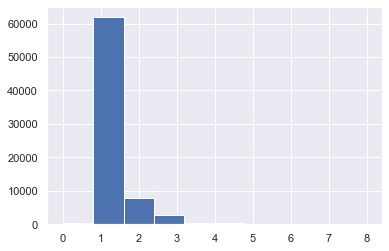

In [16]:
all_df['bathrooms'].hist()

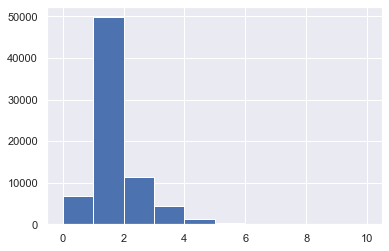

In [17]:
all_df['bedrooms'].hist()

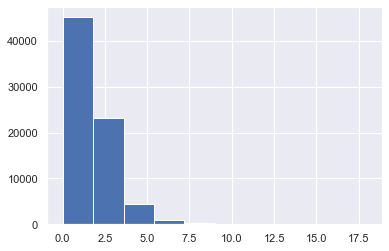

In [18]:
all_df['beds'].hist()

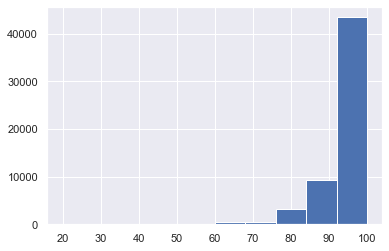

In [19]:
all_df['review_scores_rating'].hist()

In [20]:
all_df[all_df['amenities'].apply(lambda x: len(x)) < 10]['amenities'].value_counts()

{}           586
{Kitchen}      7
{TV}           1
Name: amenities, dtype: int64

## データ補正

### nullの対処

In [21]:
all_df['bathrooms'] = all_df['bathrooms'].fillna(-1)
all_df['bedrooms'] = all_df['bedrooms'].fillna(-1)
all_df['beds'] = all_df['beds'].fillna(-1)
all_df['review_scores_rating'] = all_df['review_scores_rating'].fillna('-1')
all_df['host_response_rate'] = all_df['host_response_rate'].fillna('-1%')

In [22]:
all_df['thumbnail_url'] = all_df['thumbnail_url'].fillna('')

In [23]:
all_df['has_thumbnail_url'] = all_df['thumbnail_url'].apply(lambda x: 0 if x == '' else 1)
all_df['has_thumbnail_url'].head()

0    0
1    1
2    1
3    0
4    1
Name: has_thumbnail_url, dtype: int64

In [24]:
all_df['last_review'] = all_df['last_review'].fillna('2099-12-31')
all_df['first_review'] = all_df['first_review'].fillna('1900-01-01')
all_df['host_since'] = all_df['host_since'].fillna('1900-01-01')
all_df['last_review'] = pd.to_datetime(all_df['last_review'], format='%Y-%m-%d')
all_df['first_review'] = pd.to_datetime(all_df['first_review'], format='%Y-%m-%d')
all_df['host_since'] = pd.to_datetime(all_df['host_since'], format='%Y-%m-%d')

In [25]:
import datetime

def passed_days(x):
    return str(datetime.datetime.now() - x).split(' ')[0]

In [26]:
all_df['during_last_review'] = all_df['last_review'].apply(passed_days)
all_df['during_first_review'] = all_df['first_review'].apply(passed_days)
all_df['during_host_since'] = all_df['host_since'].apply(passed_days)


In [27]:
all_df['host_has_profile_pic'] = all_df['host_has_profile_pic'].fillna('none')
all_df['host_identity_verified'] = all_df['host_identity_verified'].fillna('none')
all_df['neighbourhood'] = all_df['neighbourhood'].fillna('none')


zipcodeは意味がないので追及はやめる

In [28]:
all_df.isnull().sum()

accommodates                0
amenities                   0
bathrooms                   0
bed_type                    0
bedrooms                    0
beds                        0
cancellation_policy         0
city                        0
cleaning_fee                0
description                 0
first_review                0
host_has_profile_pic        0
host_identity_verified      0
host_response_rate          0
host_since                  0
instant_bookable            0
last_review                 0
latitude                    0
longitude                   0
name                        0
neighbourhood               0
number_of_reviews           0
property_type               0
review_scores_rating        0
room_type                   0
thumbnail_url               0
zipcode                   966
y                           0
has_thumbnail_url           0
during_last_review          0
during_first_review         0
during_host_since           0
dtype: int64

### その他対処

In [29]:
all_df['host_response_rate'] =all_df['host_response_rate'].apply(lambda x: x if x == -1 else x[:-1])
all_df['host_response_rate']

0         -1
1        100
2        100
3        100
4        100
        ... 
74106    100
74107    100
74108    100
74109    100
74110    100
Name: host_response_rate, Length: 74111, dtype: object

In [30]:
all_df['host_response_rate'].value_counts()

100    43254
-1     18299
90      2277
80      1113
0        883
       ...  
23         1
6          1
39         1
21         1
31         1
Name: host_response_rate, Length: 81, dtype: int64

In [31]:
all_df['bed_type'].value_counts()

Real Bed         72028
Futon              753
Pull-out Sofa      585
Airbed             477
Couch              268
Name: bed_type, dtype: int64

In [32]:
all_df['cancellation_policy'].value_counts()

strict             32374
flexible           22545
moderate           19063
super_strict_30      112
super_strict_60       17
Name: cancellation_policy, dtype: int64

In [33]:
all_df['city'].value_counts()

NYC        32349
LA         22453
SF          6434
DC          5688
Chicago     3719
Boston      3468
Name: city, dtype: int64

In [34]:
all_df['cleaning_fee'].value_counts()

t    54403
f    19708
Name: cleaning_fee, dtype: int64

In [35]:
all_df['host_has_profile_pic'].value_counts()

t       73697
f         226
none      188
Name: host_has_profile_pic, dtype: int64

In [36]:
all_df['host_identity_verified'].value_counts()

t       49748
f       24175
none      188
Name: host_identity_verified, dtype: int64

In [37]:
all_df['instant_bookable'].value_counts()

f    54660
t    19451
Name: instant_bookable, dtype: int64

In [38]:
all_df['neighbourhood'].value_counts()

none                                   6872
Williamsburg                           2862
Bedford-Stuyvesant                     2166
Bushwick                               1601
Upper West Side                        1396
                                       ... 
Hilcrest Heights/Marlow Heights, MD       1
Edison Park                               1
Chillum, MD                               1
Newton                                    1
Country Club                              1
Name: neighbourhood, Length: 620, dtype: int64

In [39]:
all_df['property_type'].value_counts()

Apartment             49003
House                 16511
Condominium            2658
Townhouse              1692
Loft                   1244
Other                   607
Guesthouse              498
Bed & Breakfast         462
Bungalow                366
Villa                   179
Dorm                    142
Guest suite             123
Camper/RV                94
Timeshare                77
Cabin                    72
In-law                   71
Hostel                   70
Boutique hotel           69
Boat                     65
Serviced apartment       21
Tent                     18
Castle                   13
Vacation home            11
Yurt                      9
Hut                       8
Treehouse                 7
Chalet                    6
Earth House               4
Tipi                      3
Train                     2
Cave                      2
Island                    1
Parking Space             1
Casa particular           1
Lighthouse                1
Name: property_type,

In [40]:
all_df['room_type'].value_counts()

Entire home/apt    41310
Private room       30638
Shared room         2163
Name: room_type, dtype: int64

In [41]:
ab = [
    'bed_type',
    'cancellation_policy',
    'city',
    'cleaning_fee',
    'host_has_profile_pic',
    'host_identity_verified',
    'instant_bookable',
    'neighbourhood',
    'property_type',
    'room_type',
]

In [42]:
for column in ab:
    le = preprocessing.LabelEncoder()
    le.fit(all_df[column])
    all_df[column] = le.transform(all_df[column])

In [43]:
ac = [
    'bed_type',
    'cancellation_policy',
    'city',
    'cleaning_fee',
    'host_has_profile_pic',
    'host_identity_verified',
    'instant_bookable',
    'neighbourhood',
    'property_type',
    'room_type',

    'host_response_rate',
    'has_thumbnail_url',

    'y',
]

In [44]:
all_df2 = all_df[ac]
all_df2

,bed_type,cancellation_policy,city,cleaning_fee,host_has_profile_pic,host_identity_verified,instant_bookable,neighbourhood,property_type,room_type,host_response_rate,has_thumbnail_url,y
0,4,0,3,1,2,0,0,619,0,1,-1,0,138.0
1,4,2,2,1,2,2,0,74,17,1,100,1,42.0
2,4,2,4,1,2,0,1,84,0,1,100,1,65.0
3,4,2,5,1,2,2,1,390,0,1,100,0,166.0
4,4,2,4,1,2,2,0,556,0,0,100,1,165.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
74106,4,2,4,1,2,2,0,238,0,0,100,1,-999.0
74107,4,0,1,0,2,0,0,299,0,0,100,0,-999.0
74108,4,0,1,1,2,0,0,27,17,0,100,1,-999.0
74109,4,2,4,1,2,0,0,165,0,0,100,1,-999.0


In [45]:
all_df['amenities']

0        {TV,"Wireless Internet",Kitchen,"Free parking ...
1        {TV,"Cable TV",Internet,"Wireless Internet","A...
2        {TV,Internet,"Wireless Internet",Kitchen,"Indo...
3        {TV,"Cable TV",Internet,"Wireless Internet","A...
4        {TV,Internet,"Wireless Internet","Air conditio...
                               ...                        
74106    {TV,Internet,"Wireless Internet","Air conditio...
74107    {TV,"Wireless Internet","Air conditioning",Kit...
74108    {TV,"Wireless Internet","Air conditioning",Kit...
74109    {Internet,"Wireless Internet","Air conditionin...
74110    {TV,Internet,"Wireless Internet",Kitchen,"Elev...
Name: amenities, Length: 74111, dtype: object

In [46]:
amenities = []

for idx in range(all_df.shape[0]):
    _tmp = all_df.iloc[idx]['amenities']
    _row = {}
    for _amt in _tmp[1:-1].split(','):
        if _amt.find('missing:') > 0:
            _amt = 'missing'
        _row[_amt] = 1
    amenities.append(_row)


In [47]:
all_df3 = pd.DataFrame(amenities)
all_df3 = all_df3.fillna(0)
all_df3.columns = list(range(all_df3.shape[1]))
all_df3

,0,1,2,3,4,5,6,7,8,9,...,120,121,122,123,124,125,126,127,128,129
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74106,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
74107,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
74108,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
74109,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [48]:
all_df4 = pd.concat([all_df2, all_df3], axis=1)

In [49]:
all_df4

,bed_type,cancellation_policy,city,cleaning_fee,host_has_profile_pic,host_identity_verified,instant_bookable,neighbourhood,property_type,room_type,...,120,121,122,123,124,125,126,127,128,129
0,4,0,3,1,2,0,0,619,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,4,2,2,1,2,2,0,74,17,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,4,2,4,1,2,0,1,84,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,2,5,1,2,2,1,390,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,2,4,1,2,2,0,556,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74106,4,2,4,1,2,2,0,238,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
74107,4,0,1,0,2,0,0,299,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
74108,4,0,1,1,2,0,0,27,17,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
74109,4,2,4,1,2,0,0,165,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [50]:
all_df2['host_response_rate'] = all_df2['host_response_rate'].astype('int')

D:\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [51]:
all_df2.corr()[(all_df2.corr()['y'] > 0.1) | (all_df2.corr()['y'] < -0.1)]

,bed_type,cancellation_policy,city,cleaning_fee,host_has_profile_pic,host_identity_verified,instant_bookable,neighbourhood,property_type,room_type,host_response_rate,has_thumbnail_url,y
y,0.007217,0.021432,0.000557,0.008479,-0.005857,-0.005058,-0.009027,0.00793,0.02293,-0.089179,-0.012667,-0.027418,1.0


In [52]:
all_df2.corr()['y']

bed_type                  0.007217
cancellation_policy       0.021432
city                      0.000557
cleaning_fee              0.008479
host_has_profile_pic     -0.005857
host_identity_verified   -0.005058
instant_bookable         -0.009027
neighbourhood             0.007930
property_type             0.022930
room_type                -0.089179
host_response_rate       -0.012667
has_thumbnail_url        -0.027418
y                         1.000000
Name: y, dtype: float64

In [53]:
all_df.corr()['y']

accommodates              0.124230
bathrooms                 0.111925
bed_type                  0.007217
bedrooms                  0.117653
beds                      0.106415
cancellation_policy       0.021432
city                      0.000557
cleaning_fee              0.008479
host_has_profile_pic     -0.005857
host_identity_verified   -0.005058
instant_bookable         -0.009027
latitude                 -0.004361
longitude                -0.009330
neighbourhood             0.007930
number_of_reviews        -0.015070
property_type             0.022930
room_type                -0.089179
y                         1.000000
has_thumbnail_url        -0.027418
Name: y, dtype: float64

In [54]:
all_df5 = all_df4.copy()

In [55]:
all_df5.columns.drop('y')

Index([              'bed_type',    'cancellation_policy',
                         'city',           'cleaning_fee',
         'host_has_profile_pic', 'host_identity_verified',
             'instant_bookable',          'neighbourhood',
                'property_type',              'room_type',
       ...
                            120,                      121,
                            122,                      123,
                            124,                      125,
                            126,                      127,
                            128,                      129],
      dtype='object', length=142)

In [56]:
for col in all_df5.columns.drop('y'):
    std = preprocessing.StandardScaler()
    all_df5[col] = std.fit_transform(all_df5[col].values.reshape(-1, 1))

# all_df5

# all_df5.columns
# std = preprocessing.StandardScaler()
# std.fit_transform(all_df5['city'].values.reshape(-1, 1))

In [57]:
all_df5

,bed_type,cancellation_policy,city,cleaning_fee,host_has_profile_pic,host_identity_verified,instant_bookable,neighbourhood,property_type,room_type,...,120,121,122,123,124,125,126,127,128,129
0,0.152813,-1.329472,-0.247604,0.601880,0.071323,-1.435152,-0.596535,1.387126,-0.669117,0.952445,...,-0.012184,-0.003673,-0.003673,-0.003673,-0.003673,-0.003673,-0.005195,-0.009719,-0.006363,-0.003673
1,0.152813,1.010455,-1.093740,0.601880,0.071323,0.698802,-0.596535,-1.357000,1.303661,0.952445,...,-0.012184,-0.003673,-0.003673,-0.003673,-0.003673,-0.003673,-0.005195,-0.009719,-0.006363,-0.003673
2,0.152813,1.010455,0.598532,0.601880,0.071323,-1.435152,1.676347,-1.306649,-0.669117,0.952445,...,-0.012184,-0.003673,-0.003673,-0.003673,-0.003673,-0.003673,-0.005195,-0.009719,-0.006363,-0.003673
3,0.152813,1.010455,1.444668,0.601880,0.071323,0.698802,1.676347,0.234090,-0.669117,0.952445,...,-0.012184,-0.003673,-0.003673,-0.003673,-0.003673,-0.003673,-0.005195,-0.009719,-0.006363,-0.003673
4,0.152813,1.010455,0.598532,0.601880,0.071323,0.698802,-0.596535,1.069915,-0.669117,-0.850673,...,-0.012184,-0.003673,-0.003673,-0.003673,-0.003673,-0.003673,-0.005195,-0.009719,-0.006363,-0.003673
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74106,0.152813,1.010455,0.598532,0.601880,0.071323,0.698802,-0.596535,-0.531245,-0.669117,-0.850673,...,-0.012184,-0.003673,-0.003673,-0.003673,-0.003673,-0.003673,-0.005195,-0.009719,-0.006363,-0.003673
74107,0.152813,-1.329472,-1.939876,-1.661461,0.071323,-1.435152,-0.596535,-0.224104,-0.669117,-0.850673,...,-0.012184,-0.003673,-0.003673,-0.003673,-0.003673,-0.003673,-0.005195,-0.009719,-0.006363,-0.003673
74108,0.152813,-1.329472,-1.939876,0.601880,0.071323,-1.435152,-0.596535,-1.593649,1.303661,-0.850673,...,-0.012184,-0.003673,-0.003673,-0.003673,-0.003673,-0.003673,-0.005195,-0.009719,-0.006363,-0.003673
74109,0.152813,1.010455,0.598532,0.601880,0.071323,-1.435152,-0.596535,-0.898806,-0.669117,-0.850673,...,-0.012184,-0.003673,-0.003673,-0.003673,-0.003673,-0.003673,-0.005195,-0.009719,-0.006363,-0.003673


In [58]:
# (all_df3.corr()['y'] > 0.3) | (all_df3.corr()['y'] < -0.3)
all_df3_corr = pd.concat([all_df3, all_df['y']], axis=1).corr()
# all_df3_corr
all_df3_corr[(all_df3_corr['y'] > 0.1) | (all_df3_corr['y'] < -0.1)]


,0,1,2,3,4,5,6,7,8,9,...,121,122,123,124,125,126,127,128,129,y
y,0.041108,0.001185,0.017539,0.014712,0.035587,0.038277,0.005335,0.039412,0.014273,0.009928,...,0.003371,0.003371,0.003371,0.003371,0.003371,-0.003319,0.001489,0.005332,-0.006111,1.0


In [59]:
all_df5.corr()['y'][all_df5.corr()['y'] > 0.01]

cancellation_policy    0.021432
property_type          0.022930
y                      1.000000
0                      0.041108
2                      0.017539
3                      0.014712
4                      0.035587
5                      0.038277
7                      0.039412
8                      0.014273
10                     0.016606
16                     0.012700
18                     0.016542
19                     0.012945
21                     0.043251
23                     0.012037
24                     0.013791
25                     0.012987
26                     0.014734
29                     0.010853
31                     0.015996
34                     0.049110
37                     0.017729
39                     0.022242
41                     0.019917
42                     0.016888
43                     0.037538
53                     0.014746
54                     0.014813
55                     0.022848
65                     0.017293
66      

In [60]:
all_df5.corr()['y'][all_df5.corr()['y'] < -0.01]

room_type            -0.089179
host_response_rate   -0.012667
has_thumbnail_url    -0.027418
15                   -0.025241
20                   -0.045189
32                   -0.018419
33                   -0.011711
Name: y, dtype: float64

## Training

In [61]:
all_df5['y']

0        138.0
1         42.0
2         65.0
3        166.0
4        165.0
         ...  
74106   -999.0
74107   -999.0
74108   -999.0
74109   -999.0
74110   -999.0
Name: y, Length: 74111, dtype: float64

In [62]:
X = all_df5[all_df5['y'] != -999].drop(['y'], axis=1)
y = all_df5[all_df5['y'] != -999]['y']

In [63]:
X = X.astype('float')

In [64]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=0)

### PyTorch

In [82]:
import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F

In [83]:
batch_size = 64
n_epochs = 1000

In [84]:
train_X = torch.tensor(X_train.values, dtype=torch.float32)
train_y = torch.tensor(y_train.values, dtype=torch.float32)

In [85]:
device = 'cuda:0'

# to GPU
train_X = train_X.to(device)
train_y = train_y.to(device)


In [86]:
train = TensorDataset(train_X, train_y)
# print(train[0])

train_loader = DataLoader(train, batch_size=batch_size, shuffle=True)

In [87]:
class Net(nn.Module):
    def __init__(self, col_num):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(col_num, 144)
        self.fc2 = nn.Linear(144, 72)
        self.fc3 = nn.Linear(72, 18)
        self.fc4 = nn.Linear(18, 1)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        return x
    
net = Net(X_train.shape[1])
net.to(device)

Net(
  (fc1): Linear(in_features=142, out_features=144, bias=True)
  (fc2): Linear(in_features=144, out_features=72, bias=True)
  (fc3): Linear(in_features=72, out_features=18, bias=True)
  (fc4): Linear(in_features=18, out_features=1, bias=True)
)

In [88]:
# 損失関数
# criterion = nn.CrossEntropyLoss() # 他クラス分類:ソフトマックス交差エントロピー誤差
criterion = nn.MSELoss() # 回帰:平均二乗誤差
# criterion = nn.L1Loss() # 回帰:平均絶対値誤差
# criterion = nn.BCELoss() # 二値分類:バイナリ交差エントロピー
# criterion = nn.BCEWithLogitsLoss() # 二値分類:ロジット・バイナリ交差エントロピー

# 最適化関数
# optimizer = optim.SGD(net.parameters(), lr=0.01)
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [90]:
for epoch in range(n_epochs):
    total_loss = 0
    
    for i, data in enumerate(train_loader):
        inputs, labels = data
        
        optimizer.zero_grad()
        
        outputs = net(inputs)
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    if (epoch+i)%10 == 0:
        print(epoch+1, total_loss)


4 17056678.810058594
14 17053258.82421875
24 17047055.752441406
34 17046799.75341797
44 17058632.33251953


KeyboardInterrupt: 

In [ ]:
test_X = torch.tensor(X_test.values, dtype=torch.float32)
test_X = test_X.to(device)

result = net(test_X)

In [ ]:
result